In [1]:
from modules.utils import load_datasets_statforecast_uni
data_path = '/Users/moji/PyTSF-MfG/data'
datasets = load_datasets_statforecast_uni(data_path)

/Users/moji/PyTSF-MfG/data/AirPassengers.csv
(144, 3)
/Users/moji/PyTSF-MfG/data/ETTh1.csv
(17420, 3)


In [2]:
datasets['ETTh1']

,unique_id,ds,y
0,1,2016-07-01 00:00:00,30.531000
1,1,2016-07-01 01:00:00,27.787001
2,1,2016-07-01 02:00:00,27.787001
3,1,2016-07-01 03:00:00,25.044001
4,1,2016-07-01 04:00:00,21.948000
...,...,...,...
17415,1,2018-06-26 15:00:00,10.904000
17416,1,2018-06-26 16:00:00,11.044000
17417,1,2018-06-26 17:00:00,10.271000
17418,1,2018-06-26 18:00:00,9.778000


In [3]:
from darts import TimeSeries
import pandas as pd
import numpy as np
# Convert 'ds' column to datetime
df = datasets['ETTh1']
df['ds'] = pd.to_datetime(df['ds'])
# Set 'ds' column as the index
df.set_index('ds', inplace=True)
df = df.astype(np.float32)

series = TimeSeries.from_times_and_values(datasets['ETTh1'].index, datasets['ETTh1']['y'], freq='h')
series.astype(dtype=np.float32)
series

<TimeSeries (DataArray) (ds: 17420, component: 1, sample: 1)> Size: 139kB
array([[[30.53100014]],

       [[27.78700066]],

       [[27.78700066]],

       ...,

       [[10.27099991]],

       [[ 9.77799988]],

       [[ 9.56700039]]])
Coordinates:
  * ds         (ds) datetime64[ns] 139kB 2016-07-01 ... 2018-06-26T19:00:00
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [4]:
series.pd_dataframe()

component,0
ds,
2016-07-01 00:00:00,30.531000
2016-07-01 01:00:00,27.787001
2016-07-01 02:00:00,27.787001
2016-07-01 03:00:00,25.044001
2016-07-01 04:00:00,21.948000
...,...
2018-06-26 15:00:00,10.904000
2018-06-26 16:00:00,11.044000
2018-06-26 17:00:00,10.271000


<Axes: xlabel='ds'>

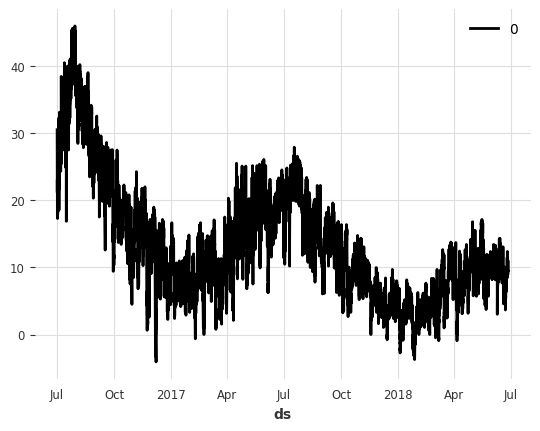

In [5]:
series.plot()

In [6]:
train, test = series.split_before(0.8)
len(train), len(test)

(13935, 3485)

In [7]:
from darts.dataprocessing.transformers import Scaler
# Scale the data
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [8]:
from modules.algorithm_factory import create_algorithm

algorithm_name = 'TCN'
model = create_algorithm(algorithm_name)
model

{'name': 'TCN', 'class': 'darts.models.TCNModel', 'params': {'input_chunk_length': 50, 'output_chunk_length': 3, 'output_chunk_shift': 0, 'num_layers': 3, 'num_filters': 64, 'kernel_size': 3, 'n_epochs': 20, 'force_reset': 'True', 'pl_trainer_kwargs': {'accelerator': 'cpu'}}, 'data_format': 'Darts'}


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=64, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=3, n_epochs=20, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'})

In [9]:
model.fit(train_scaled)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 50.1 K | train
-------------------------------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=64, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=3, n_epochs=20, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'})

In [10]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [11]:
forecasting_horizon = 3
predictions = model.predict(forecasting_horizon)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
# Make predictions
prediction_length = len(test_scaled)
predictions = []
history = train_scaled  # Start with the training data as history

for i in range(0, prediction_length, model.output_chunk_length):
    n = min(model.output_chunk_length, prediction_length - i)
    pred = model.predict(n=n, series=history, verbose=False)
    predictions.append(pred)
    
    # Update history with the true values
    history = history.append(test_scaled[i:i+n])

In [19]:
len(predictions)

1162

In [20]:
combined_predictions = predictions[0]
for pred in predictions[1:]:
    combined_predictions = combined_predictions.concatenate(pred)

In [21]:
predictions = scaler.inverse_transform(combined_predictions)

In [24]:
len(predictions)

3485

In [30]:
from modules.evaluator import Evaluator

actual = test.pd_dataframe()
forecast = predictions.pd_dataframe()

In [34]:
metrics = Evaluator.calculate_metrics(actual.values, forecast.values)
metrics

{'MSE': 1.1454418860109283,
 'RSME': 1.0702531878069452,
 'MAE': 0.7412535217886567,
 'WAPE': 0.09601490445073069,
 'MAPE': 84291447.84436785,
 'SMAPE': 14.296027075246794,
 'RAE': 0.25464569708233875,
 'RSE': 0.3105741574162042,
 'MASE': 1.6542658002129298,
 'R2': 0.9035436927452148}

In [35]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

MSE: 1.1454418860109283
RSME: 1.0702531878069452
MAE: 0.7412535217886567
WAPE: 0.09601490445073069
MAPE: 84291447.84436785
SMAPE: 14.296027075246794
RAE: 0.25464569708233875
RSE: 0.3105741574162042
MASE: 1.6542658002129298
R2: 0.9035436927452148


In [36]:
from modules.results_saver import ResultsSaver
ALGORITHM = "TCN"
OUTPUT_DIR = '/Users/moji/PyTSF-MfG/results'
saver = ResultsSaver(OUTPUT_DIR)
name = 'ETTh1'

saver.save_results(metrics, ALGORITHM, name)
print(f"Experiments completed for {ALGORITHM} on {name} and results saved.")

Experiments completed for TCN on ETTh1 and results saved.


In [38]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_forecast(actual, forecast, title="TCN Model Forecast"):
    plt.figure(figsize=(12, 6))
    
    # Convert to pandas Series if they're not already
    if not isinstance(actual, pd.Series):
        if isinstance(actual, pd.DataFrame):
            actual = actual.iloc[:, 0]  # Take first column if it's a DataFrame
        else:
            actual = pd.Series(actual)
    
    if not isinstance(forecast, pd.Series):
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.iloc[:, 0]  # Take first column if it's a DataFrame
        else:
            forecast = pd.Series(forecast, index=actual.index[-len(forecast):])

    # Plot actual values
    plt.plot(actual.index, actual.values, label='Actual', color='blue')
    
    # Plot forecast values
    plt.plot(forecast.index, forecast.values, label='Forecast', color='red', linestyle='--')
    
    # Shade the forecast area
    plt.fill_between(forecast.index, forecast.values, actual.iloc[-len(forecast):],
                     color='red', alpha=0.3)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

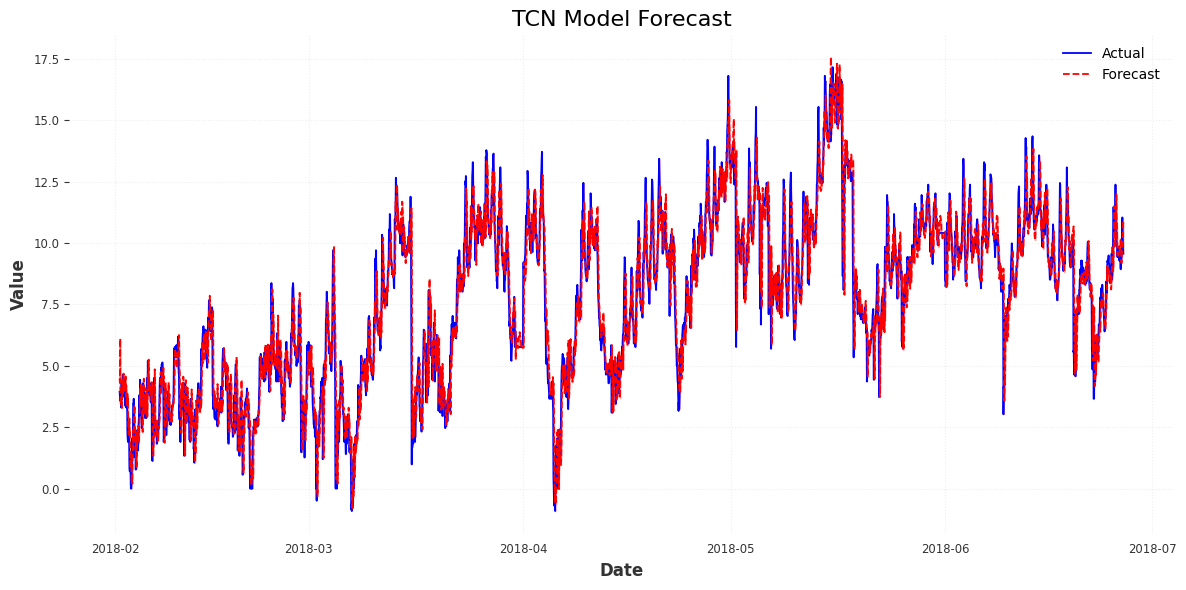

In [39]:
plot_forecast(actual, forecast)

In [44]:
from modules.seasonality import find_seasonal_period
period = find_seasonal_period(train.pd_dataframe(), max_lag=100)
print(f"Estimated seasonal period: {period}")

Estimated seasonal period: 22


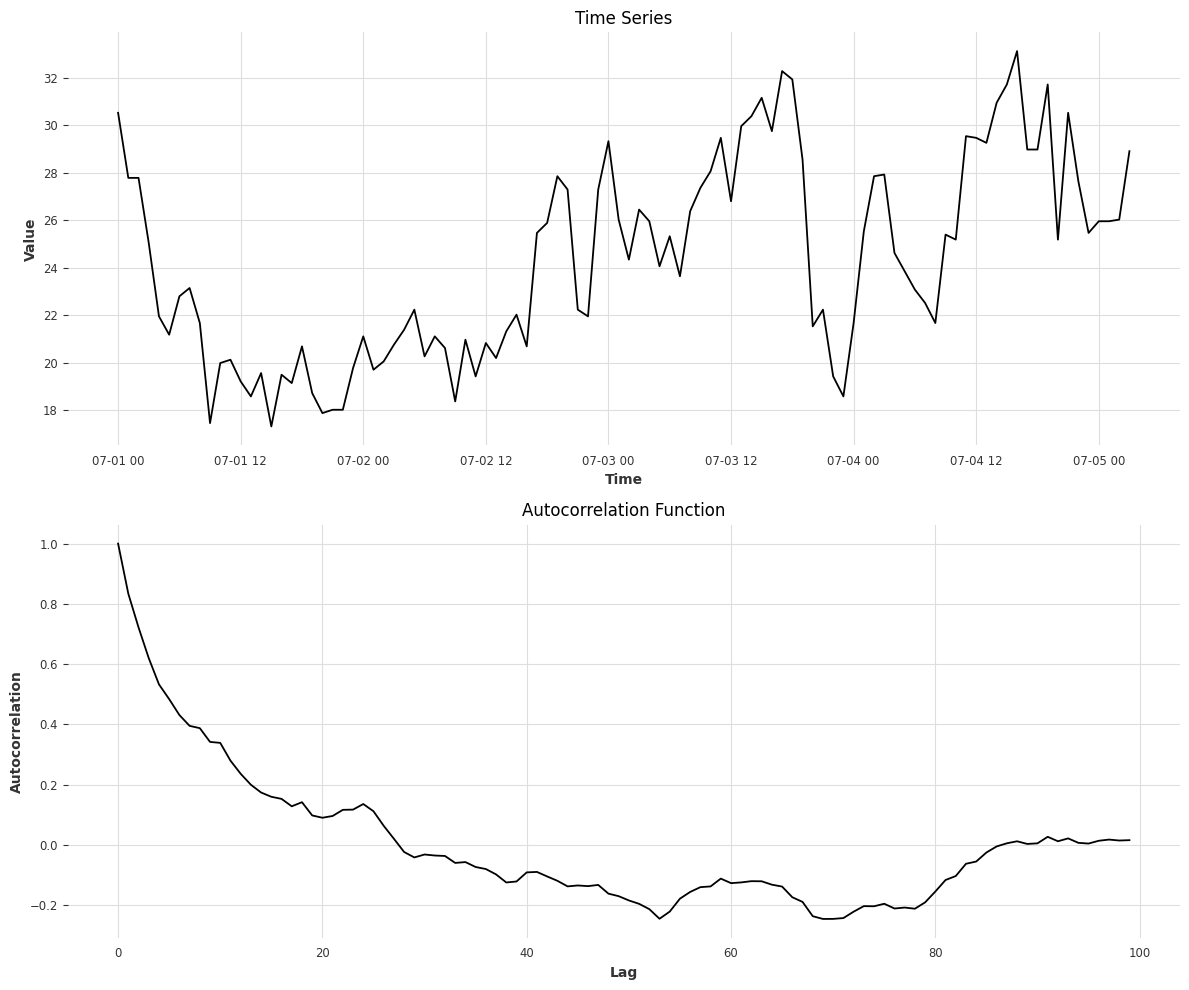

In [46]:
from statsmodels.tsa.stattools import acf

# Plot the time series and its autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(train.time_index[0:100], train.values()[0:100])
ax1.set_title("Time Series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")

ax2.plot(acf(train.values()[0:100], nlags=100))
ax2.set_title("Autocorrelation Function")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()